Importing libraries, and setting up global parameters - number of oscillator eigenstates to compute, number of points to sampled the oscillator wavefunctions at, and number of points to conduct filter diagonalisation (no. of sigma values), and the lower and upper bound of sigma values

In [1]:
import numpy as np
import scipy
from matplotlib import rc
from scipy.special import factorial
import matplotlib.pyplot as plt
from minresScipy import *
import math
import pandas as pd
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)
print("Hello World")
sigma_n = 8
sigma_lower = 0
sigma_upper = 10

maxit = 200000
dropped_elements = 3


# Maximum vibrational quantum number to calculate wavefunction for
VMAX = 16
#Number of points to sample
POINTS_NUM = 15

Hello World


# Creating Harmonic Oscillator Hamiltonian

Here, we create the harmonic oscillator's eigenfunctions, plot them, and create the matrices B, B'', V, C = B^-1 B'', U = B^-1 V B, H' = C + U

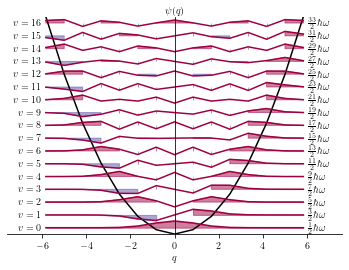

In [2]:
# PLOT_PROB=False plots the wavefunction, psi; PLOT_PROB=True plots |psi|^2
PLOT_PROB = False
# Some appearance settings
# Pad the q-axis on each side of the maximum turning points by this fraction
QPAD_FRAC = 1.3
# Scale the wavefunctions by this much so they don't overlap
SCALING = 0.7
# Colours of the positive and negative parts of the wavefunction
COLOUR1 = (0.6196, 0.0039, 0.2588, 1.0)
COLOUR2 = (0.3686, 0.3098, 0.6353, 1.0)

# Normalization constant and energy for vibrational state v
N = lambda v: 1./np.sqrt(np.sqrt(np.pi)*2**v*factorial(v))
get_E = lambda v: v + 0.5

def make_Hr():
    """Return a list of np.poly1d objects representing Hermite polynomials."""

    # Define the Hermite polynomials up to order VMAX by recursion:
    # H_[v] = 2qH_[v-1] - 2(v-1)H_[v-2]
    Hr = [None] * (VMAX + 1)
    Hr[0] = np.poly1d([1.,])
    Hr[1] = np.poly1d([2., 0.])
    for v in range(2, VMAX+1):
        Hr[v] = Hr[1]*Hr[v-1] - 2*(v-1)*Hr[v-2]
    return Hr

Hr = make_Hr()

def get_psi(v, q):
    """Return the harmonic oscillator wavefunction for level v on grid q."""
    return N(v)*Hr[v](q)*np.exp(-q*q/2.)

def get_turning_points(v):
    """Return the classical turning points for state v."""
    qmax = np.sqrt(2. * get_E(v + 0.5))
    return -qmax, qmax

def get_potential(q):
    """Return potential energy on scaled oscillator displacement grid q."""
    return q**2 / 2


fig, ax = plt.subplots()
qmin, qmax = get_turning_points(VMAX)
xmin, xmax = QPAD_FRAC * qmin, QPAD_FRAC * qmax
q = np.linspace(qmin, qmax, POINTS_NUM)
V = get_potential(q)

bList = []
eList =[]
def plot_func(ax, f, scaling=1, yoffset=0):
    """Plot f*scaling with offset yoffset.

    The curve above the offset is filled with COLOUR1; the curve below is
    filled with COLOUR2.

    """
    ax.plot(q, f*scaling + yoffset, color=COLOUR1)
    ax.fill_between(q, f*scaling + yoffset, yoffset, f > 0.,
                    color=COLOUR1, alpha=0.5)
    ax.fill_between(q, f*scaling + yoffset, yoffset, f < 0.,
                    color=COLOUR2, alpha=0.5)

# Plot the potential, V(q).
ax.plot(q, V, color='k', linewidth=1.5)

# Plot each of the wavefunctions (or probability distributions) up to VMAX.
for v in range(VMAX+1):
    psi_v = get_psi(v, q)
    E_v = get_E(v)

    bList.append(psi_v)
    eList.append(E_v)
    if PLOT_PROB:
        plot_func(ax, psi_v**2, scaling=SCALING*1.5, yoffset=E_v)
    else:
        plot_func(ax, psi_v, scaling=SCALING, yoffset=E_v)
    # The energy, E = (v+0.5).hbar.omega.
    ax.text(s=r'$\frac{{{}}}{{2}}\hbar\omega$'.format(2*v+1), x=qmax+0.2,
            y=E_v, va='center')
    # Label the vibrational levels.
    ax.text(s=r'$v={}$'.format(v), x=qmin-0.2, y=E_v, va='center', ha='right')

# The top of the plot, plus a bit.
ymax = E_v+0.5

if PLOT_PROB:
    ylabel = r'$|\psi(q)|^2$'
else:
    ylabel = r'$\psi(q)$'
ax.text(s=ylabel, x=0, y=ymax, va='bottom', ha='center')

ax.set_xlabel('$q$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(0, ymax)
ax.spines['left'].set_position('center')
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig('sho-psi{}-{}.png'.format(PLOT_PROB+1, VMAX))
plt.show()

In [3]:
#Creating our new matrices

#B Matrix 
Nvalue = VMAX - 1
B = np.stack(bList[:Nvalue], axis = 1)#If I had 500 grid points -> 500 rows, 11 wave fuunctions -> 11 columns
evalues_B = np.diag(eList)
#B'' matrix
def b_prime_generator(b_vectors, N):
    
    b_primeList = []
    for i in range(N):
        if i > 1:
            b_prime = 0.5*(np.sqrt((i+1)*(i+2))*b_vectors[i+2] + np.sqrt(i*(i-1))*b_vectors[i-2] - (2*i +1)*b_vectors[i])
        
        elif i <=1:
            b_prime = 0.5*(np.sqrt((i+1)*(i+2))*b_vectors[i+2] - (2*i +1)*b_vectors[i])
        b_primeList.append(b_prime)

    return b_primeList

b_primeList = b_prime_generator(bList,Nvalue)

B_prime = np.stack(b_primeList, axis = 1)

#C matrix
C = np.matmul(np.linalg.inv(B),B_prime)

#Potential Matrix
U = np.matmul(np.linalg.inv(B), np.matmul(np.diag(V), B))

#H' patrix
H_prime = -0.5*C + U

Check that none of C, U, H' are symmetric

In [4]:


def is_symmetric(A, tol=1e-8):
    return scipy.linalg.norm(A-A.T, scipy.Inf) < tol;

print(is_symmetric(C))
print(is_symmetric(U))
print(is_symmetric(H_prime))

False
False
True


Calculate the eigenvalues of H', C, U, V, correct to 2 decimal places

In [5]:
print("H'")
print(np.around(np.linalg.eigvals(H_prime),2))
print("C")
print(np.around(np.linalg.eigvals(C),2))
print("U")
print(np.around(np.linalg.eigvals(U),2))
print("V")
print(np.around(np.linalg.eigvals(np.diag(V)),2))

H'
[ 0.5 14.5  1.5 13.5 12.5 11.5 10.5  3.5  9.5  8.5  4.5  7.5  5.5  6.5
  2.5]
C
[-1.422e+01+0.j   -3.080e+00+7.47j -3.080e+00-7.47j -1.000e+00+2.66j
 -1.000e+00-2.66j -2.730e+00+8.7j  -2.730e+00-8.7j  -2.200e-01+0.57j
 -2.200e-01-0.57j -9.500e-01+3.41j -9.500e-01-3.41j -1.000e-02+0.j
 -2.400e-01+0.91j -2.400e-01-0.91j -3.000e-02+0.j  ]
U
[17.  +0.j 17.  +0.j -0.  +0.j 12.49+0.j 12.49-0.j  8.67+0.j  8.67-0.j
  5.55+0.j  5.55+0.j  3.12+0.j  3.12+0.j  0.35+0.j  0.35+0.j  1.39+0.j
  1.39+0.j]
V
[17.   12.49  8.67  5.55  3.12  1.39  0.35  0.    0.35  1.39  3.12  5.55
  8.67 12.49 17.  ]


Displaying the matrices seen so far

In [6]:
# #Outputs matrix in LaTeX Formatting
# def print_latex_matrix(matrix):
#     rows = len(matrix)
#     cols = len(matrix[0])

#     # # Round to 1 decimal place and replace -0.0 with 0.0
#     # rounded_matrix = [[int(round(x, 0)) if x != 0.0 or math.copysign(1, x) != -1 else 0.0 for x in row] for row in matrix]

#     print("\\begin{bmatrix}")
#     for i in range(rows):
#         row_str = " & ".join(map(str, matrix[i]))#rounded_matrix[i]))
#         if i < rows - 1:
#             row_str += " \\\\"
#         print(f"  {row_str}")
#     print("\\end{bmatrix}")
# print_latex_matrix(np.around(H_prime,2))


Everything is rounded upto 2 decimal places for readability; each matrix is 15 x 15
### B
$
\begin{bmatrix}
  0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.01 & -0.02 & 0.04 & -0.08 & 0.13 \\
  0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.01 & -0.02 & 0.05 & -0.09 & 0.15 & -0.24 & 0.34 & -0.44 & 0.51 \\
  0.0 & -0.0 & 0.0 & -0.01 & 0.03 & -0.06 & 0.12 & -0.21 & 0.33 & -0.45 & 0.52 & -0.5 & 0.35 & -0.09 & -0.19 \\
  0.0 & -0.01 & 0.04 & -0.11 & 0.22 & -0.36 & 0.49 & -0.55 & 0.45 & -0.19 & -0.14 & 0.38 & -0.39 & 0.13 & 0.2 \\
  0.03 & -0.12 & 0.27 & -0.45 & 0.57 & -0.49 & 0.19 & 0.2 & -0.43 & 0.32 & 0.05 & -0.36 & 0.31 & 0.04 & -0.34 \\
  0.19 & -0.44 & 0.6 & -0.46 & 0.02 & 0.39 & -0.39 & -0.01 & 0.38 & -0.29 & -0.15 & 0.38 & -0.12 & -0.29 & 0.29 \\
  0.53 & -0.63 & 0.15 & 0.41 & -0.37 & -0.17 & 0.42 & -0.03 & -0.38 & 0.17 & 0.3 & -0.27 & -0.19 & 0.32 & 0.08 \\
  0.75 & 0.0 & -0.53 & 0.0 & 0.46 & 0.0 & -0.42 & 0.0 & 0.39 & 0.0 & -0.37 & 0.0 & 0.36 & 0.0 & -0.34 \\
  0.53 & 0.63 & 0.15 & -0.41 & -0.37 & 0.17 & 0.42 & 0.03 & -0.38 & -0.17 & 0.3 & 0.27 & -0.19 & -0.32 & 0.08 \\
  0.19 & 0.44 & 0.6 & 0.46 & 0.02 & -0.39 & -0.39 & 0.01 & 0.38 & 0.29 & -0.15 & -0.38 & -0.12 & 0.29 & 0.29 \\
  0.03 & 0.12 & 0.27 & 0.45 & 0.57 & 0.49 & 0.19 & -0.2 & -0.43 & -0.32 & 0.05 & 0.36 & 0.31 & -0.04 & -0.34 \\
  0.0 & 0.01 & 0.04 & 0.11 & 0.22 & 0.36 & 0.49 & 0.55 & 0.45 & 0.19 & -0.14 & -0.38 & -0.39 & -0.13 & 0.2 \\
  0.0 & 0.0 & 0.0 & 0.01 & 0.03 & 0.06 & 0.12 & 0.21 & 0.33 & 0.45 & 0.52 & 0.5 & 0.35 & 0.09 & -0.19 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.01 & 0.02 & 0.05 & 0.09 & 0.15 & 0.24 & 0.34 & 0.44 & 0.51 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.01 & 0.02 & 0.04 & 0.08 & 0.13
\end{bmatrix}
$
### B''
$
\begin{bmatrix}
  0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.01 & -0.02 & 0.04 & -0.07 & 0.14 & -0.25 & 0.39 & -0.54 & 0.64 \\
  0.0 & -0.0 & 0.0 & -0.01 & 0.02 & -0.05 & 0.11 & -0.22 & 0.36 & -0.52 & 0.6 & -0.47 & -0.01 & 0.9 & -2.04 \\
  0.0 & -0.01 & 0.04 & -0.1 & 0.22 & -0.38 & 0.53 & -0.5 & 0.11 & 0.74 & -1.91 & 2.83 & -2.67 & 0.87 & 2.26 \\
  0.03 & -0.11 & 0.27 & -0.44 & 0.45 & -0.04 & -0.94 & 2.13 & -2.64 & 1.5 & 1.42 & -4.57 & 5.35 & -2.14 & -3.61 \\
  0.17 & -0.38 & 0.33 & 0.34 & -1.56 & 2.34 & -1.29 & -1.75 & 4.61 & -4.04 & -0.78 & 6.0 & -5.91 & -0.73 & 7.66 \\
  0.33 & 0.1 & -1.34 & 1.94 & -0.12 & -3.22 & 4.03 & 0.14 & -5.37 & 4.64 & 2.65 & -7.6 & 2.59 & 6.9 & -7.65 \\
  -0.16 & 1.44 & -0.63 & -2.6 & 3.06 & 1.79 & -5.17 & 0.37 & 6.23 & -3.2 & -6.04 & 6.07 & 4.68 & -8.53 & -2.36 \\
  -0.75 & 0.0 & 2.66 & 0.0 & -4.14 & 0.0 & 5.46 & 0.0 & -6.68 & 0.0 & 7.82 & 0.0 & -8.92 & 0.0 & 9.97 \\
  -0.16 & -1.44 & -0.63 & 2.6 & 3.06 & -1.79 & -5.17 & -0.37 & 6.23 & 3.2 & -6.04 & -6.07 & 4.68 & 8.53 & -2.36 \\
  0.33 & -0.1 & -1.34 & -1.94 & -0.12 & 3.22 & 4.03 & -0.14 & -5.37 & -4.64 & 2.65 & 7.6 & 2.59 & -6.9 & -7.65 \\
  0.17 & 0.38 & 0.33 & -0.34 & -1.56 & -2.34 & -1.29 & 1.75 & 4.61 & 4.04 & -0.78 & -6.0 & -5.91 & 0.73 & 7.66 \\
  0.03 & 0.11 & 0.27 & 0.44 & 0.45 & 0.04 & -0.94 & -2.13 & -2.64 & -1.5 & 1.42 & 4.57 & 5.35 & 2.14 & -3.61 \\
  0.0 & 0.01 & 0.04 & 0.1 & 0.22 & 0.38 & 0.53 & 0.5 & 0.11 & -0.74 & -1.91 & -2.83 & -2.67 & -0.87 & 2.26 \\
  0.0 & 0.0 & 0.0 & 0.01 & 0.02 & 0.05 & 0.11 & 0.22 & 0.36 & 0.52 & 0.6 & 0.47 & -0.01 & -0.9 & -2.04 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.01 & 0.02 & 0.04 & 0.07 & 0.14 & 0.25 & 0.39 & 0.54 & 0.64
\end{bmatrix}
$
### C = B^-1 B''
$
\begin{bmatrix}
  -0.5 & -0.0 & 0.71 & 0.0 & -0.0 & -0.0 & -0.0 & 0.0 & 0.0 & 0.0 & -0.0 & -0.0 & -0.0 & 0.0 & 7.22 \\
  0.0 & -1.5 & -0.0 & 1.22 & -0.0 & -0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -0.0 & 0.0 & 27.0 & 0.0 \\
  0.71 & -0.0 & -2.5 & 0.0 & 1.73 & -0.0 & 0.0 & 0.0 & -0.0 & 0.0 & 0.0 & -0.0 & -0.0 & -0.0 & -41.42 \\
  0.0 & 1.22 & -0.0 & -3.5 & -0.0 & 2.24 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & 0.0 & -111.51 & -0.0 \\
  -0.0 & -0.0 & 1.73 & 0.0 & -4.5 & -0.0 & 2.74 & 0.0 & 0.0 & 0.0 & -0.0 & 0.0 & 0.0 & 0.0 & 77.71 \\
  -0.0 & 0.0 & -0.0 & 2.24 & 0.0 & -5.5 & 0.0 & 3.24 & -0.0 & -0.0 & 0.0 & -0.0 & 0.0 & 229.77 & 0.0 \\
  0.0 & 0.0 & 0.0 & -0.0 & 2.74 & 0.0 & -6.5 & -0.0 & 3.74 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & -55.26 \\
  0.0 & -0.0 & -0.0 & 0.0 & -0.0 & 3.24 & -0.0 & -7.5 & 0.0 & 4.24 & -0.0 & 0.0 & -0.0 & -290.87 & -0.0 \\
  -0.0 & 0.0 & 0.0 & -0.0 & 0.0 & 0.0 & 3.74 & 0.0 & -8.5 & -0.0 & 4.74 & -0.0 & -0.0 & -0.0 & -25.84 \\
  -0.0 & 0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & 4.24 & -0.0 & -9.5 & 0.0 & 5.24 & 0.0 & 242.0 & 0.0 \\
  0.0 & -0.0 & -0.0 & 0.0 & -0.0 & -0.0 & 0.0 & 0.0 & 4.74 & 0.0 & -10.5 & 0.0 & 5.74 & 0.0 & 87.02 \\
  0.0 & -0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & -0.0 & 0.0 & 5.24 & -0.0 & -11.5 & -0.0 & -126.32 & -0.0 \\
  -0.0 & 0.0 & 0.0 & -0.0 & -0.0 & 0.0 & 0.0 & -0.0 & -0.0 & -0.0 & 5.74 & -0.0 & -12.5 & -0.0 & -72.97 \\
  -0.0 & 0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & 0.0 & -0.0 & -0.0 & 0.0 & 6.24 & 0.0 & 31.14 & 0.0 \\
  0.0 & -0.0 & -0.0 & 0.0 & 0.0 & -0.0 & -0.0 & 0.0 & 0.0 & 0.0 & -0.0 & 0.0 & 6.75 & -0.0 & 22.64
\end{bmatrix}
$
### V
$
\begin{bmatrix}
  17.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
  0.0 & 12.49 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
  0.0 & 0.0 & 8.67 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
  0.0 & 0.0 & 0.0 & 5.55 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 3.12 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.39 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.35 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.35 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.39 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 3.12 & 0.0 & 0.0 & 0.0 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 5.55 & 0.0 & 0.0 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 8.67 & 0.0 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 12.49 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 17.0
\end{bmatrix}
$
### U = B^-1 V B
$
\begin{bmatrix}
  0.25 & -0.0 & 0.35 & 0.0 & 0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & 3.61 \\
  -0.0 & 0.75 & 0.0 & 0.61 & 0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & -0.0 & -0.0 & 13.5 & 0.0 \\
  0.35 & 0.0 & 1.25 & 0.0 & 0.87 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -20.71 \\
  0.0 & 0.61 & 0.0 & 1.75 & -0.0 & 1.12 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & -55.76 & -0.0 \\
  -0.0 & 0.0 & 0.87 & 0.0 & 2.25 & 0.0 & 1.37 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 38.85 \\
  -0.0 & 0.0 & -0.0 & 1.12 & -0.0 & 2.75 & 0.0 & 1.62 & 0.0 & -0.0 & -0.0 & -0.0 & -0.0 & 114.88 & -0.0 \\
  -0.0 & 0.0 & 0.0 & 0.0 & 1.37 & 0.0 & 3.25 & 0.0 & 1.87 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & -27.63 \\
  0.0 & -0.0 & 0.0 & -0.0 & 0.0 & 1.62 & -0.0 & 3.75 & -0.0 & 2.12 & -0.0 & 0.0 & 0.0 & -145.43 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.87 & -0.0 & 4.25 & -0.0 & 2.37 & -0.0 & -0.0 & -0.0 & -12.92 \\
  -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & 0.0 & 2.12 & 0.0 & 4.75 & 0.0 & 2.62 & -0.0 & 121.0 & -0.0 \\
  0.0 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & 2.37 & 0.0 & 5.25 & 0.0 & 2.87 & 0.0 & 43.51 \\
  0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & -0.0 & -0.0 & -0.0 & 2.62 & -0.0 & 5.75 & 0.0 & -63.16 & 0.0 \\
  0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -0.0 & -0.0 & 2.87 & -0.0 & 6.25 & -0.0 & -36.48 \\
  -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -0.0 & 0.0 & 3.12 & 0.0 & 29.07 & -0.0 \\
  -0.0 & -0.0 & -0.0 & 0.0 & -0.0 & -0.0 & -0.0 & -0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 3.37 & -0.0 & 25.82
\end{bmatrix}
$
### H' = C + U
$
\begin{bmatrix}
  -0.25 & -0.0 & 1.06 & 0.0 & -0.0 & -0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & 10.82 \\
  0.0 & -0.75 & 0.0 & 1.84 & -0.0 & -0.0 & -0.0 & 0.0 & -0.0 & 0.0 & 0.0 & -0.0 & 0.0 & 40.5 & 0.0 \\
  1.06 & -0.0 & -1.25 & 0.0 & 2.6 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -0.0 & 0.0 & -62.12 \\
  0.0 & 1.84 & -0.0 & -1.75 & -0.0 & 3.35 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & 0.0 & -167.27 & -0.0 \\
  -0.0 & -0.0 & 2.6 & 0.0 & -2.25 & -0.0 & 4.11 & 0.0 & 0.0 & 0.0 & -0.0 & 0.0 & 0.0 & 0.0 & 116.56 \\
  -0.0 & 0.0 & -0.0 & 3.35 & -0.0 & -2.75 & 0.0 & 4.86 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & 344.65 & 0.0 \\
  -0.0 & 0.0 & 0.0 & 0.0 & 4.11 & 0.0 & -3.25 & 0.0 & 5.61 & -0.0 & 0.0 & -0.0 & -0.0 & -0.0 & -82.89 \\
  0.0 & -0.0 & 0.0 & 0.0 & 0.0 & 4.86 & -0.0 & -3.75 & -0.0 & 6.36 & -0.0 & 0.0 & 0.0 & -436.3 & -0.0 \\
  -0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 5.61 & -0.0 & -4.25 & -0.0 & 7.12 & -0.0 & -0.0 & -0.0 & -38.76 \\
  -0.0 & 0.0 & -0.0 & -0.0 & -0.0 & -0.0 & 0.0 & 6.36 & 0.0 & -4.75 & 0.0 & 7.87 & -0.0 & 363.0 & 0.0 \\
  0.0 & -0.0 & -0.0 & 0.0 & -0.0 & -0.0 & -0.0 & -0.0 & 7.12 & 0.0 & -5.25 & 0.0 & 8.62 & 0.0 & 130.53 \\
  0.0 & -0.0 & 0.0 & 0.0 & -0.0 & -0.0 & -0.0 & -0.0 & -0.0 & 7.87 & -0.0 & -5.75 & -0.0 & -189.48 & -0.0 \\
  -0.0 & 0.0 & 0.0 & -0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -0.0 & -0.0 & 8.62 & -0.0 & -6.25 & -0.0 & -109.45 \\
  -0.0 & 0.0 & -0.0 & -0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -0.0 & 0.0 & 9.37 & 0.0 & 60.21 & 0.0 \\
  -0.0 & -0.0 & -0.0 & 0.0 & -0.0 & -0.0 & -0.0 & -0.0 & 0.0 & 0.0 & -0.0 & 0.0 & 10.12 & -0.0 & 48.46
\end{bmatrix}
$

# Using MINRES + Filter Diagonalization

We perform MINRES + Filter Diagonalization and SVD on H'. 
First, for MINRES we geenrate the arbitrary starting vector, and the various sigma values for Filter Diagonalisation.

In [7]:
#Generate the random vector
s = np.random.normal(0, 1, POINTS_NUM)

norm=math.sqrt(sum(s*s))
S=s/norm

#Picking sigma to be uniformly distributed between sigma_lower and sigma_upper

sigma = np.linspace(sigma_lower,sigma_upper,sigma_n )
print("The Sigma Values are:",sigma)

The Sigma Values are: [ 0.          1.42857143  2.85714286  4.28571429  5.71428571  7.14285714
  8.57142857 10.        ]


We Solve the Linear equation 

In [8]:
print("We use the matrix H'")

V_regular = np.zeros((sigma_n,POINTS_NUM))
V_minres = np.zeros((sigma_n,POINTS_NUM))
for i in range(sigma_n):
    V_regular[i] = np.dot(np.linalg.inv(sigma[i]*np.eye(POINTS_NUM) - H_prime),S)
    V_minres[i], exitcode = minres((sigma[i]*np.eye(POINTS_NUM) - H_prime), S, maxiter = maxit, tol = np.float32(1e-9))
    
for i in range(sigma_n):
    print("\nSigma = ", sigma[i])
    print("Maximal difference between any component of Vi calculated by MINRES, and that calculated by the exact solver = ", max(abs(V_minres[i] - V_regular[i])))
    print("Smallest Component in V (exact) = ", min(abs(V_regular[i])))
    print("Median Component by magnitude in V (exact) = ", np.median(np.sort(abs(V_regular[i]))))
    print("Exitcode = ", exitcode)


We use the matrix H'

Sigma =  0.0
Maximal difference between any component of Vi calculated by MINRES, and that calculated by the exact solver =  6.231126725708691e-15
Smallest Component in V (exact) =  0.0010783066767994925
Median Component by magnitude in V (exact) =  0.025259333180736976
Exitcode =  0

Sigma =  1.4285714285714286
Maximal difference between any component of Vi calculated by MINRES, and that calculated by the exact solver =  2.523807551835233e-12
Smallest Component in V (exact) =  0.0014566598967284364
Median Component by magnitude in V (exact) =  0.02686796647625435
Exitcode =  0

Sigma =  2.857142857142857
Maximal difference between any component of Vi calculated by MINRES, and that calculated by the exact solver =  9.157875846543817e-12
Smallest Component in V (exact) =  0.002244043624688265
Median Component by magnitude in V (exact) =  0.03511728297477544
Exitcode =  0

Sigma =  4.285714285714286
Maximal difference between any component of Vi calculated by MINRES

Examining the outcome for a particular sigma value

In [9]:
print("Sigma = ", sigma[1])
print("\nVi by exact solver = ", V_regular[1])
print("\nVi by MINRES = ", V_minres[1])
print("\nThe Vi(regular) - Vi(MINRES) = ", V_regular[1] - V_minres[1])

Sigma =  1.4285714285714286

Vi by exact solver =  [ 2.25207481e-02 -2.07038135e+00  2.37754292e-01  2.62875675e-02
  1.87836630e-02  1.45665990e-03 -7.41244948e-02 -2.19282730e-02
 -3.67283402e-02  5.22294712e-02  5.93350261e-02 -2.88422173e-02
 -5.72933711e-03 -2.33884386e-03 -2.68679665e-02]

Vi by MINRES =  [ 2.25207481e-02 -2.07038135e+00  2.37754292e-01  2.62875675e-02
  1.87836630e-02  1.45665990e-03 -7.41244948e-02 -2.19282730e-02
 -3.67283402e-02  5.22294712e-02  5.93350261e-02 -2.88422173e-02
 -5.72933711e-03 -2.33884386e-03 -2.68679665e-02]

The Vi(regular) - Vi(MINRES) =  [ 4.30766534e-14 -8.25561841e-13 -4.36040093e-14 -1.73472348e-17
 -1.38777878e-17 -1.51788304e-18  2.22044605e-16 -1.04083409e-17
  4.16333634e-17  6.86950496e-16 -2.09554596e-15 -8.63892291e-16
 -3.38271078e-16 -6.01949046e-16 -2.52380755e-12]


Performing the next stage of the process by creating and solving the generalized eigenvalue equation 

In [10]:
#Creating the H and S matrices
Hmatrix = np.ones((sigma_n,sigma_n))
Smatrix = np.ones((sigma_n,sigma_n))

Hmatrix_minres = np.ones((sigma_n,sigma_n))
Smatrix_minres = np.ones((sigma_n,sigma_n))

matrix = H_prime

for i in range(sigma_n):
    for j in range(sigma_n):
        Hmatrix[i,j]= np.dot(V_regular[i],np.dot(matrix,V_regular[j]))
        Hmatrix_minres[i,j]= np.dot(V_minres[i],np.dot(matrix,V_minres[j]))
        Smatrix[i,j] = np.dot(V_regular[i],V_regular[j])
        Smatrix_minres[i,j] = np.dot(V_minres[i],V_minres[j])


print(Hmatrix.shape)
print(Smatrix.shape) 

(8, 8)
(8, 8)


Now, we solve the generalized Eigenvalue Equation for the matrices.

In [11]:
def eigenvalues_in_range(matrix, sigma_lower = sigma_lower, sigma_upper = sigma_upper):
    # Calculate eigenvalues
    eigenvalues = np.linalg.eigvals(matrix)

    # Filter eigenvalues within the specified range
    eigenvalues_in_range = [eigval for eigval in eigenvalues if sigma_lower <= eigval <= sigma_upper]

    return eigenvalues_in_range



eigenvalues_filtered_H_prime = eigenvalues_in_range(H_prime)




eigvals, eigvecs = scipy.linalg.eigh(Hmatrix, b = Smatrix,eigvals_only=False)
eigvals_minres, eigvecs_minres = scipy.linalg.eigh(Hmatrix_minres, b = Smatrix_minres,eigvals_only=False)
print("The sigma values are - ", sigma)
print("Exact Solver : Solved eigenvalues - ", eigvals)
print("MINRES : Solved eigenvalues - ", eigvals_minres)
print("Std. Solver's e-values - MINRES e-values = ", eigvals - eigvals_minres)
#print("The Symmetric Matrix B's eigenvalues between 0 to 2 are : ", eigB[:8])
print(f"The Matrix H prime's eigenvalues between {sigma_lower} to {sigma_upper}are : {eigenvalues_filtered_H_prime} ")
#eigvalMINRES, exitcode = minres(Hmatrix, Smatrix)

The sigma values are -  [ 0.          1.42857143  2.85714286  4.28571429  5.71428571  7.14285714
  8.57142857 10.        ]
Exact Solver : Solved eigenvalues -  [ 1.49801407  2.47660085  3.536602    4.64412648  6.53978254  8.46213961
  8.99653741 10.37999   ]
MINRES : Solved eigenvalues -  [ 1.49801407  2.47660085  3.53660199  4.64412648  6.53978254  8.46213961
  8.99653741 10.37999   ]
Std. Solver's e-values - MINRES e-values =  [ 3.35287353e-13  2.23150387e-11  1.58431757e-09  3.42310180e-10
 -1.97013073e-10 -1.18230759e-10  6.09983175e-10 -8.81534845e-11]
The Matrix H prime's eigenvalues between 0 to 10are : [0.5, 1.4999999999999987, 3.4999999999999964, 9.500000000000009, 8.499999999999991, 4.5, 7.5, 5.500000000000003, 6.5, 2.500000000000002] 


We perform SVD (To be debugged)

In [12]:
S_evals, S_evecs = np.linalg.eig(Smatrix)

S_evecs = S_evecs.T

Lambda = S_evals*np.eye(sigma_n,sigma_n)
Z = S_evecs[:(sigma_n - dropped_elements)]
Lambda_Trunc = S_evals[:(sigma_n - dropped_elements)]*np.eye(sigma_n - dropped_elements,sigma_n - dropped_elements)


spl_Z = Z[1:]
spl_Lambda_Trunc = S_evals[1:(sigma_n - dropped_elements)]*np.eye(sigma_n - dropped_elements-1,sigma_n - dropped_elements-1)

S_evals_minres, S_evecs_minres = np.linalg.eig(Smatrix_minres)

S_evecs_minres = S_evecs_minres.T

Lambda_minres = S_evals_minres*np.eye(sigma_n,sigma_n)
Z_minres = S_evecs_minres[:(sigma_n - dropped_elements)]
Lambda_Trunc_minres = S_evals_minres[:(sigma_n - dropped_elements)]*np.eye(sigma_n - dropped_elements,sigma_n - dropped_elements)


spl_Z_minres = Z[1:]
spl_Lambda_Trunc_minres = S_evals_minres[1:(sigma_n - dropped_elements)]*np.eye(sigma_n - dropped_elements-1,sigma_n - dropped_elements-1)



In [13]:
#Solving the Generalized EV equation
eigvals1, eigvecs1 = scipy.linalg.eigh(Hmatrix, b = Smatrix,eigvals_only=False)
eigvals_minres1, eigvecs_minres1 = scipy.linalg.eigh(Hmatrix_minres, b = Smatrix_minres,eigvals_only=False)
print("The sigma values are - ", sigma)
print("Exact Solver : Solved eigenvalues - ", eigvals1)
print("MINRES : Solved eigenvalues - ", eigvals_minres1)
print("Std. Solver's e-values - MINRES e-values = ", eigvals1 - eigvals_minres1)
#print("The Symmetric Matrix B's eigenvalues between 0 to 2 are : ", eigB[:8])
print(f"The Matrix H prime's eigenvalues between {sigma_lower} to {sigma_upper}are : {eigenvalues_filtered_H_prime} ")
#eigvalMINRES, exitcode = minres(Hmatrix, Smatrix)

The sigma values are -  [ 0.          1.42857143  2.85714286  4.28571429  5.71428571  7.14285714
  8.57142857 10.        ]
Exact Solver : Solved eigenvalues -  [ 1.49801407  2.47660085  3.536602    4.64412648  6.53978254  8.46213961
  8.99653741 10.37999   ]
MINRES : Solved eigenvalues -  [ 1.49801407  2.47660085  3.53660199  4.64412648  6.53978254  8.46213961
  8.99653741 10.37999   ]
Std. Solver's e-values - MINRES e-values =  [ 3.35287353e-13  2.23150387e-11  1.58431757e-09  3.42310180e-10
 -1.97013073e-10 -1.18230759e-10  6.09983175e-10 -8.81534845e-11]
The Matrix H prime's eigenvalues between 0 to 10are : [0.5, 1.4999999999999987, 3.4999999999999964, 9.500000000000009, 8.499999999999991, 4.5, 7.5, 5.500000000000003, 6.5, 2.500000000000002] 
